<a href="https://colab.research.google.com/github/abaskon/Particle_Filter_Localisation/blob/main/AMCL_DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = (20,8)
mpl.rcParams['axes.grid'] =False

In [2]:
!git clone https://github.com/abaskon/Particle_Filter_Localisation.git

Cloning into 'Particle_Filter_Localisation'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 30 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [39]:
amcl = pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/amcl_pose.csv')
odom_f =  pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/odometry-filtered.csv') 
odom =  pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/odom.csv')
tf =  pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/tf.csv')
clock =  pd.read_csv('https://raw.githubusercontent.com/abaskon/Particle_Filter_Localisation/main/CSV/clock.csv')

In [52]:
tf.info

<bound method DataFrame.info of           Time                                         transforms
0       34.674  [header: \n  seq: 0\n  stamp: \n    secs: 34\n...
1       34.695  [header: \n  seq: 0\n  stamp: \n    secs: 34\n...
2       34.696  [header: \n  seq: 0\n  stamp: \n    secs: 34\n...
3       34.700  [header: \n  seq: 0\n  stamp: \n    secs: 34\n...
4       34.707  [header: \n  seq: 0\n  stamp: \n    secs: 34\n...
...        ...                                                ...
29758  293.440  [header: \n  seq: 0\n  stamp: \n    secs: 293\...
29759  293.451  [header: \n  seq: 0\n  stamp: \n    secs: 293\...
29760  293.462  [header: \n  seq: 0\n  stamp: \n    secs: 293\...
29761  293.463  [header: \n  seq: 0\n  stamp: \n    secs: 293\...
29762  293.474  [header: \n  seq: 0\n  stamp: \n    secs: 293\...

[29763 rows x 2 columns]>

In [15]:
amcl_position = amcl.pivot("pose.pose.position.x","pose.pose.position.y")

In [22]:
import pandas as pd
from pandas_datareader import data
import seaborn as sns
sns.set(style="darkgrid")

In [42]:
tf.head()

,Time,transforms
0,34.674,[header: \n seq: 0\n stamp: \n secs: 34\n...
1,34.695,[header: \n seq: 0\n stamp: \n secs: 34\n...
2,34.696,[header: \n seq: 0\n stamp: \n secs: 34\n...
3,34.700,[header: \n seq: 0\n stamp: \n secs: 34\n...
4,34.707,[header: \n seq: 0\n stamp: \n secs: 34\n...


No handles with labels found to put in legend.


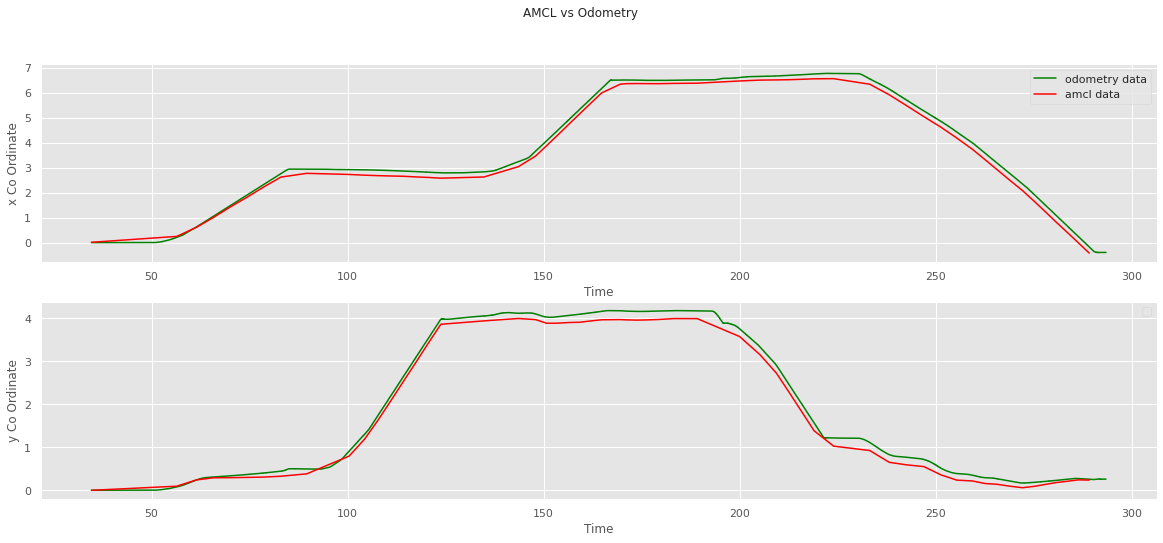

In [84]:
plt.style.use('ggplot')

fig, ax = plt.subplots(2)
fig.suptitle('AMCL vs Odometry')
# Plot 0
ax[0].plot(odom_f.Time, odom_f["pose.pose.position.x"], color="green")
ax[0].plot(amcl.Time, amcl["pose.pose.position.x"], color="red")
ax[0].set(xlabel='Time', ylabel='x Co Ordinate')
ax[0].legend(["odometry data", "amcl data"], loc ="upper right")

# Plot 1
ax[1].plot(odom_f.Time, odom_f["pose.pose.position.y"], color="green")
ax[1].plot(amcl.Time, amcl["pose.pose.position.y"], color="red")
ax[1].set(xlabel='Time', ylabel='y Co Ordinate')

# show legend
plt.legend()

# show graph
plt.show()

In [58]:
print(tf.transforms[0])

[header: 
  seq: 0
  stamp: 
    secs: 34
    nsecs: 673000000
  frame_id: "odom"
child_frame_id: "base_link"
transform: 
  translation: 
    x: -2.623981862493764e-06
    y: 1.5445277362241195e-05
    z: 0.0
  rotation: 
    x: 0.0
    y: 0.0
    z: 0.00012176224696851707
    w: 0.9999999925869776]
